# U-Net segmentation test
## Dataset: https://www.kaggle.com/datasets/tapakah68/segmentation-full-body-mads-dataset

In [1]:
train_model = True
use_mixed_precision = False

## Imports

In [2]:
import os, gc, sys, PIL
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import cv2

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold, StratifiedGroupKFold, GroupShuffleSplit
from IPython.display import display, clear_output
from PIL import Image
from collections import Counter
import albumentations as A

D:\anaconda3\envs\Gabriel_PROATEC\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [4]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.python.keras.engine import data_adapter
from tensorflow.python.keras.engine import compile_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, Conv2D, Conv2DTranspose, DepthwiseConv2D,
                                      MaxPooling2D,  UpSampling2D, ZeroPadding2D, GlobalAveragePooling2D, 
                                      SpatialDropout2D, Dropout, BatchNormalization, Normalization, 
                                      Rescaling, Reshape, Flatten,
                                      RandomFlip, RandomCrop, RandomBrightness, RandomTranslation, RandomRotation, RandomZoom, RandomContrast, 
                                      Activation, Input, Lambda, 
                                      Add, Multiply, Concatenate)
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.utils import Sequence


### Import network

In [5]:
from UNet import UNet

### Set custom options

In [6]:
pd.pandas.set_option('display.max_columns', None)
#pd.pandas.set_option('display.max_rows', None)
#np.set_printoptions(threshold=sys.maxsize)

In [7]:
tf.get_logger().setLevel('ERROR')

## Start GPUs, set Mixed-precision Policy and Random Seed

In [8]:
tf.keras.utils.set_random_seed(42)

In [9]:
gpus = len(tf.config.list_physical_devices('GPU'))

if gpus<=1: 
    strategy = tf.distribute.OneDeviceStrategy(device="/GPU:0")
    reduction = 'sum_over_batch_size'
    print(f'Using {gpus} GPU')
else: 
    strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.ReductionToOneDevice())
    reduction = None

Using 1 GPU


In [10]:
if use_mixed_precision: policy = tf.keras.mixed_precision.Policy('mixed_float16'); K.set_epsilon(1e-3)
else: policy = tf.keras.mixed_precision.Policy('float32'); K.set_epsilon(1e-7)
tf.keras.mixed_precision.set_global_policy(policy)
print(f'Compute dtype: {policy.compute_dtype}')
print(f'Variable dtype: {policy.variable_dtype}')

Compute dtype: float32
Variable dtype: float32


## Augmentation Layer

In [11]:
class Augmentation(tf.keras.layers.Layer):
    def __init__(self, squeeze=True, fm='nearest', seed=42):
        super().__init__()
        factor = (np.pi*2)/(2*np.pi)
        self.RR_x, self.RR_y = RandomRotation(factor=factor, seed=seed, fill_mode=fm), RandomRotation(factor=factor, seed=seed, fill_mode=fm)
        hf, wf = 0.2, None
        self.RZ_x, self.RZ_y = RandomZoom(height_factor=hf, width_factor=wf, seed=seed, fill_mode=fm), RandomZoom(height_factor=hf, width_factor=wf, seed=seed, fill_mode=fm)
        hf, wf = 0.15, 0.15
        self.RT_x, self.RT_y = RandomTranslation(height_factor=hf, width_factor=wf, seed=seed, fill_mode=fm), RandomTranslation(height_factor=hf, width_factor=wf, seed=seed, fill_mode=fm)
        self.squeeze = squeeze
        self.fm = fm
        
    def call(self, x, y):
        if len(x.shape)<3: x = tf.expand_dims(x, axis=-1)
        if len(y.shape)<3: y = tf.expand_dims(y, axis=-1)
        x, y = self.RZ_x(x), self.RZ_y(y)
        x, y = self.RR_x(x), self.RR_y(y)
        x, y = self.RT_x(x), self.RT_y(y)
        if self.squeeze: x, y = tf.squeeze(x), tf.squeeze(y)
        return x, y

    def get_config(self):
        config = super().get_config()
        return config 

## TF Data Loader class

In [12]:
class DataLoader(Sequence):
    def __init__(self, x, y, batch_size, shuffle = False, augment = False, from_disk = None, cv_idx = None, garbage_collection = True):
        super().__init__()
        self.from_disk = (from_disk is not None) # whether or not data will be loaded from the disk
        if self.from_disk:
            self.file = np.load(from_disk, 'r+')
            if cv_idx is None: self.length = len(self.file); self.cv_idx = np.arange(self.length)
            else: self.cv_idx = cv_idx; self.length = len(cv_idx)
        else: self.x, self.y, self.length = x, y, x.shape[0]
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        if self.augment: self.transformer = A.Affine(scale=(1., 1.1), translate_percent=(0.05, 0.1), 
                                                     rotate=(-30,30), interpolation=1, mask_interpolation=0, # interpol = 1,2
                                                     mode=1, keep_ratio=True, always_apply=False, p=0.5)
        self.indexes = np.arange(self.length)
        self.garbage_collection = garbage_collection
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(self.length/float(self.batch_size)))

    def __getitem__(self, idx):
        idx = self.indexes[idx*self.batch_size:(idx+1)*self.batch_size]
        if self.from_disk: batch_x, batch_y = self.get_batch_from_disk(idx)
        else: batch_x, batch_y = self.x[idx], self.y[idx]
        if self.augment: batch_x, batch_y = self.augmentation(batch_x, batch_y)
        if self.garbage_collection: gc.collect()
        return batch_x, batch_y

    def get_batch_from_disk(self, idx):
        batch = self.file[self.cv_idx[idx],:]
        return batch[:,:-1], batch[:,-1]

    def on_epoch_end(self):
        if self.shuffle: np.random.shuffle(self.indexes)
    
    def augmentation(self, x, y): 
        #Custom augmentation code here (if any)
        for i in range(x.shape[0]):
            x[i], y[i] = self.transformer(image=x[i], mask=y[i]).values()
        return x, y

## Data Importation

In [13]:
df = pd.read_csv('df.csv')
base_dir = 'segmentation_full_body_mads_dataset_1192_img/{0}'
img_shape, img_mode = (384, 512, 3), 'RGB'
mask_shape, mask_mode = (384, 512), 'L'
data_len = df.shape[0]
data_type = 'float32'
df.shape, df.columns

((1192, 4),
 Index(['Unnamed: 0', 'images', 'masks', 'collages'], dtype='object'))

In [14]:
df.head()

,Unnamed: 0,images,masks,collages
0,0,images/HipHop_HipHop1_C0_00180.png,masks/HipHop_HipHop1_C0_00180.png,collages/HipHop_HipHop1_C0_00180.jpg
1,1,images/HipHop_HipHop1_C0_00225.png,masks/HipHop_HipHop1_C0_00225.png,collages/HipHop_HipHop1_C0_00225.jpg
2,2,images/HipHop_HipHop1_C0_00360.png,masks/HipHop_HipHop1_C0_00360.png,collages/HipHop_HipHop1_C0_00360.jpg
3,3,images/HipHop_HipHop1_C0_00405.png,masks/HipHop_HipHop1_C0_00405.png,collages/HipHop_HipHop1_C0_00405.jpg
4,4,images/HipHop_HipHop1_C0_00450.png,masks/HipHop_HipHop1_C0_00450.png,collages/HipHop_HipHop1_C0_00450.jpg


In [15]:
X = np.zeros((data_len, img_shape[0], img_shape[1], img_shape[2]), data_type) # images
y = np.zeros((data_len, mask_shape[0], mask_shape[1]), data_type) # masks
for i, [image, mask] in enumerate(df[['images', 'masks']].values[:]):
    X[i,:,:,:] += np.array(Image.open(base_dir.format(image)).convert(img_mode), data_type)
    y[i,:,:] += np.array(Image.open(base_dir.format(mask)).convert(mask_mode), data_type) # Luminosity (foreground) and Transparency (Background)
X /= 255
y /= 255
y = (y>=.5)*1 # binary mask
gc.collect()
print('Done.')

Done.


## DisplaySegmentation Callback

In [16]:
class DisplaySegmentation(Callback):
    def __init__(self, sample_idx=None, every_t=None, clear=False, random_state=None):
        super().__init__()
        self.gen = np.random.default_rng(random_state)
        if sample_idx is None: sample_idx = np.arange(test_idx.shape[0])
        self.sample_idx = sample_idx
        if every_t is None: every_t = 1
        self.every_t = min(every_t, 1)
        self.clear = clear
        
    def on_epoch_end(self, t, logs=None):
        if t%self.every_t==0:
            if self.clear: clear_output(wait=True)
            idx = self.gen.choice(self.sample_idx)
            image = self.get_img(X[test_idx][idx], img_mode)
            mask = self.get_img(y[test_idx][idx])
            predicted_mask = self.get_img(np.squeeze(model.predict(X[test_idx][idx:idx+1]).argmax(axis=-1)))
            self.create_plot([image, mask, predicted_mask], t)
        else: pass
    
    def get_img(self, arr, mode=mask_mode):
        return Image.fromarray((255*arr).astype('uint8'), mode=mode)
    
    def create_plot(self, image_list, t, subtitles = ['Image', 'Mask', 'Predicted Mask']):
        fig, ax = plt.subplots(1,3,figsize=(14,28))
        for i in range(3):
            ax[i].imshow(image_list[i])
            ax[i].set_title(subtitles[i])              
            ax[i].axis('off')
        plt.show()

## Train model

### Get train/test indexes (avoids creating an extra copy of the arrays)

In [17]:
def train_test_index(data_len, test_size=0.25, shuffle=True, random_state=None, **kwargs):
    idx = np.arange(data_len)
    if shuffle:
        gen = np.random.default_rng(random_state)
        gen.shuffle(idx)
    slc = int(np.ceil(data_len*test_size)) # slice
    train_idx, test_idx = idx[slc:], idx[:slc]
    return (train_idx, test_idx)

train_idx, test_idx = train_test_index(data_len, 0.25, True, 42)
train_idx.shape, test_idx.shape

((894,), (298,))

### Create model and train

In [18]:
def create_model(input_shape=(384, 512, 3), param={}, opt='adam', 
                 loss=None, metrics=None, loss_weights=None, weighted_metrics=None, **kwargs):
    model_input = Input(shape=input_shape)
    model_output = UNet(2, **param)(model_input)
    model = Model(inputs=model_input, outputs=model_output, name='U-Net')
    model.compile(optimizer=opt, loss=loss, metrics=metrics,
                  loss_weights=loss_weights, weighted_metrics=weighted_metrics)
    return model

Epoch 1/12
1/1 [==============================] - 2s 2s/steps - loss: 0.0959 - pixel-wise_CE: 0.0959 - acc: 0.97


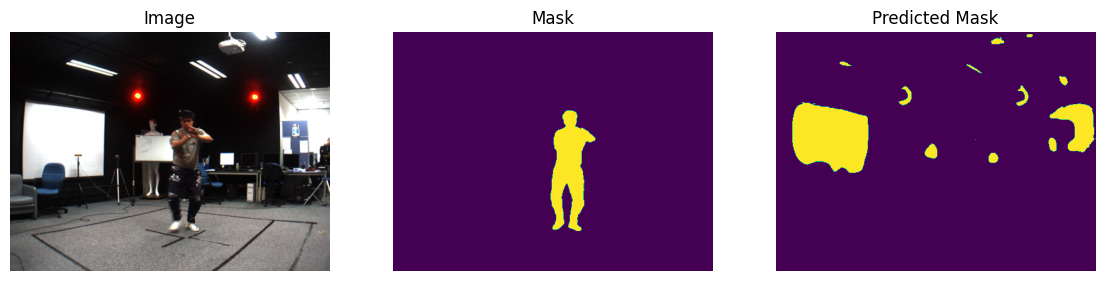

112/112 [==============================] - 175s 1s/step - loss: 0.0959 - pixel-wise_CE: 0.0959 - acc: 0.9728 - val_loss: 0.6220 - val_pixel-wise_CE: 0.6220 - val_acc: 0.9127 - lr: 0.0010
Epoch 2/12
1/1 [==============================] - 0s 130ms/step loss: 0.0200 - pixel-wise_CE: 0.0200 - acc: 0.99


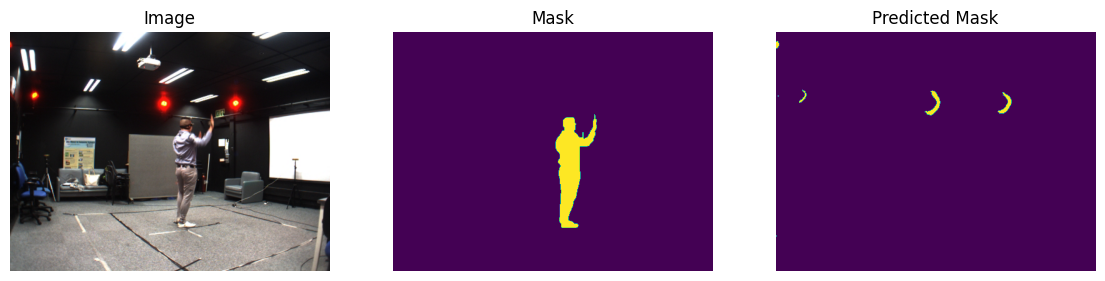

112/112 [==============================] - 75s 671ms/step - loss: 0.0200 - pixel-wise_CE: 0.0200 - acc: 0.9939 - val_loss: 0.4966 - val_pixel-wise_CE: 0.4966 - val_acc: 0.9581 - lr: 0.0010
Epoch 3/12
1/1 [==============================] - 0s 131ms/step loss: 0.0150 - pixel-wise_CE: 0.0150 - acc: 0.99


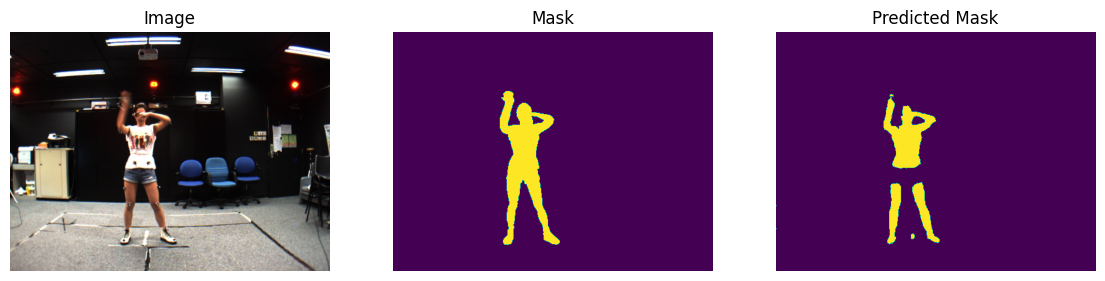

112/112 [==============================] - 76s 677ms/step - loss: 0.0150 - pixel-wise_CE: 0.0150 - acc: 0.9950 - val_loss: 0.2367 - val_pixel-wise_CE: 0.2367 - val_acc: 0.9698 - lr: 0.0010
Epoch 4/12
1/1 [==============================] - 0s 125ms/step loss: 0.0120 - pixel-wise_CE: 0.0120 - acc: 0.99


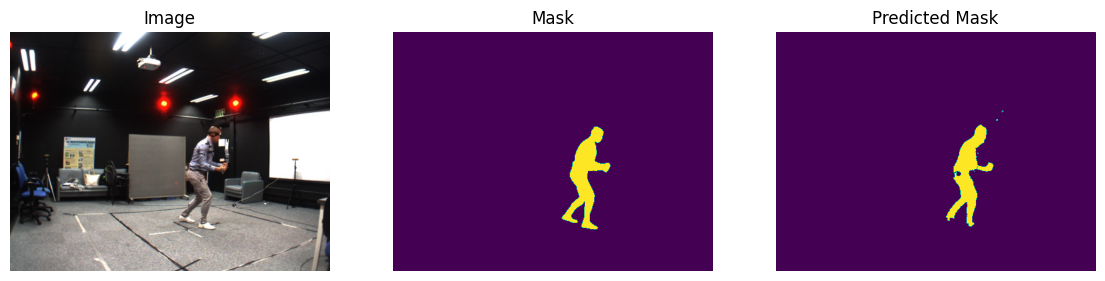

112/112 [==============================] - 76s 678ms/step - loss: 0.0120 - pixel-wise_CE: 0.0120 - acc: 0.9957 - val_loss: 0.0455 - val_pixel-wise_CE: 0.0455 - val_acc: 0.9883 - lr: 0.0010
Epoch 5/12
1/1 [==============================] - 0s 112ms/step loss: 0.0147 - pixel-wise_CE: 0.0147 - acc: 0.99


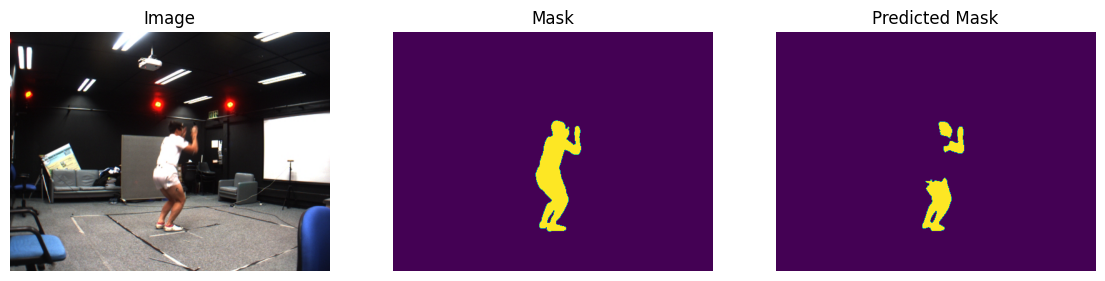

112/112 [==============================] - 75s 670ms/step - loss: 0.0147 - pixel-wise_CE: 0.0147 - acc: 0.9948 - val_loss: 0.1066 - val_pixel-wise_CE: 0.1066 - val_acc: 0.9786 - lr: 0.0010
Epoch 6/12
1/1 [==============================] - 0s 119ms/step loss: 0.0097 - pixel-wise_CE: 0.0097 - acc: 0.99


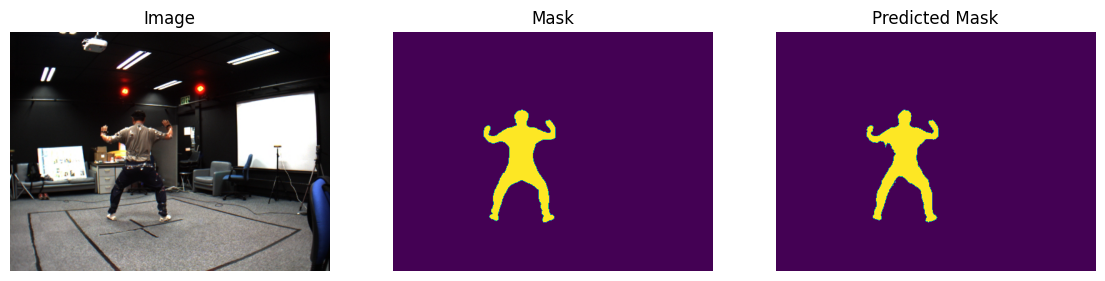

112/112 [==============================] - 76s 671ms/step - loss: 0.0097 - pixel-wise_CE: 0.0097 - acc: 0.9963 - val_loss: 0.0087 - val_pixel-wise_CE: 0.0087 - val_acc: 0.9968 - lr: 1.0000e-04
Epoch 7/12
1/1 [==============================] - 0s 128ms/step loss: 0.0090 - pixel-wise_CE: 0.0090 - acc: 0.99


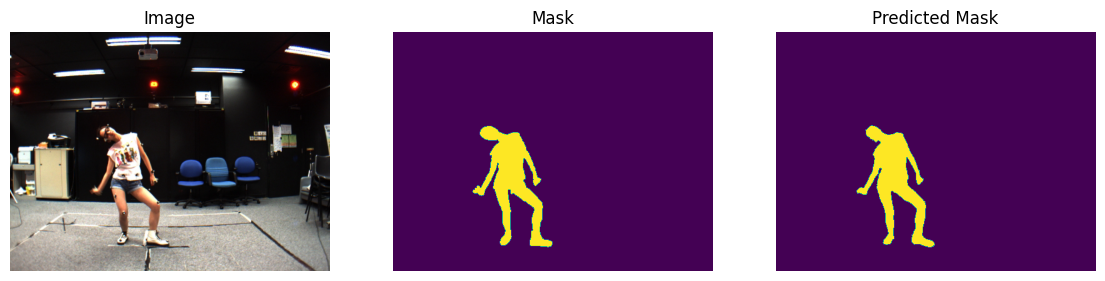

112/112 [==============================] - 75s 671ms/step - loss: 0.0090 - pixel-wise_CE: 0.0090 - acc: 0.9966 - val_loss: 0.0077 - val_pixel-wise_CE: 0.0077 - val_acc: 0.9970 - lr: 1.0000e-04
Epoch 8/12
1/1 [==============================] - 0s 130ms/step loss: 0.0087 - pixel-wise_CE: 0.0087 - acc: 0.99


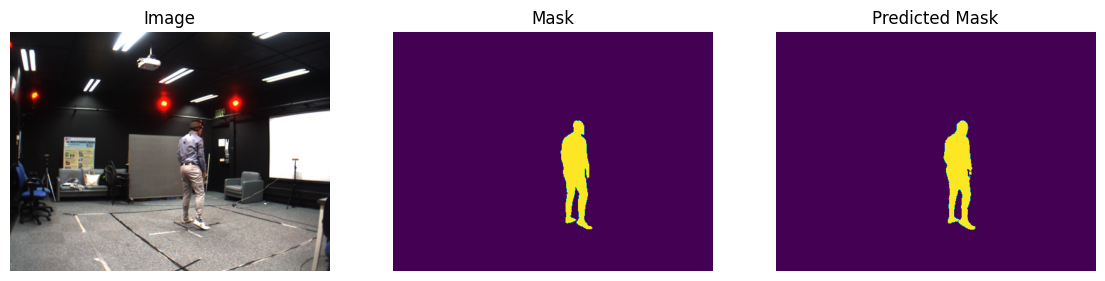

112/112 [==============================] - 76s 673ms/step - loss: 0.0087 - pixel-wise_CE: 0.0087 - acc: 0.9967 - val_loss: 0.0076 - val_pixel-wise_CE: 0.0076 - val_acc: 0.9971 - lr: 1.0000e-04
Epoch 9/12
1/1 [==============================] - 0s 152ms/step loss: 0.0087 - pixel-wise_CE: 0.0087 - acc: 0.99


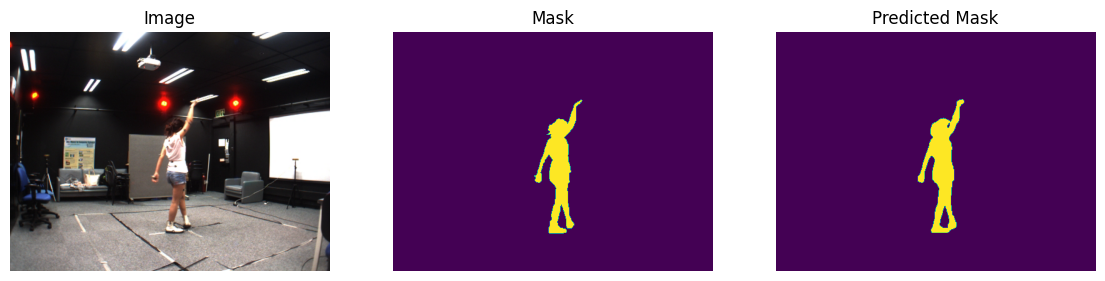

112/112 [==============================] - 75s 671ms/step - loss: 0.0087 - pixel-wise_CE: 0.0087 - acc: 0.9967 - val_loss: 0.0075 - val_pixel-wise_CE: 0.0075 - val_acc: 0.9971 - lr: 1.0000e-05
Epoch 10/12
1/1 [==============================] - 0s 105ms/step loss: 0.0086 - pixel-wise_CE: 0.0086 - acc: 0.99


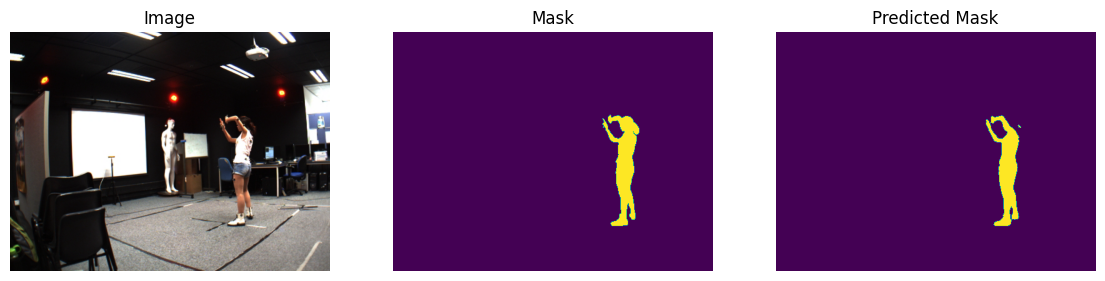

112/112 [==============================] - 76s 673ms/step - loss: 0.0086 - pixel-wise_CE: 0.0086 - acc: 0.9967 - val_loss: 0.0076 - val_pixel-wise_CE: 0.0076 - val_acc: 0.9971 - lr: 1.0000e-05
Epoch 11/12
1/1 [==============================] - 0s 103ms/step loss: 0.0085 - pixel-wise_CE: 0.0085 - acc: 0.99


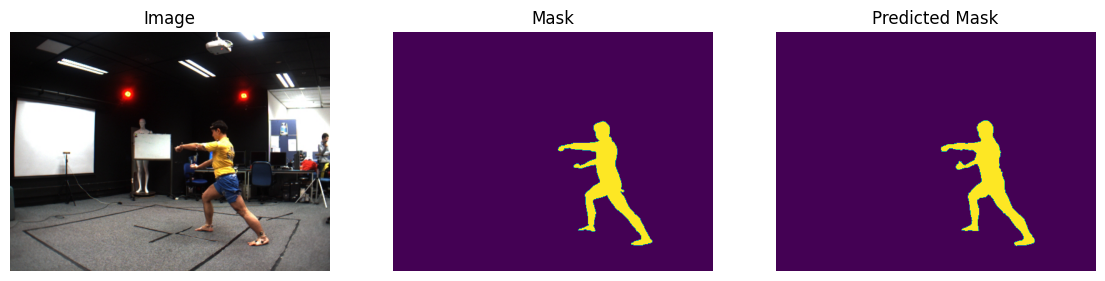

112/112 [==============================] - 76s 678ms/step - loss: 0.0085 - pixel-wise_CE: 0.0085 - acc: 0.9967 - val_loss: 0.0075 - val_pixel-wise_CE: 0.0075 - val_acc: 0.9971 - lr: 1.0000e-05
Epoch 12/12
1/1 [==============================] - 0s 113ms/step loss: 0.0085 - pixel-wise_CE: 0.0085 - acc: 0.99


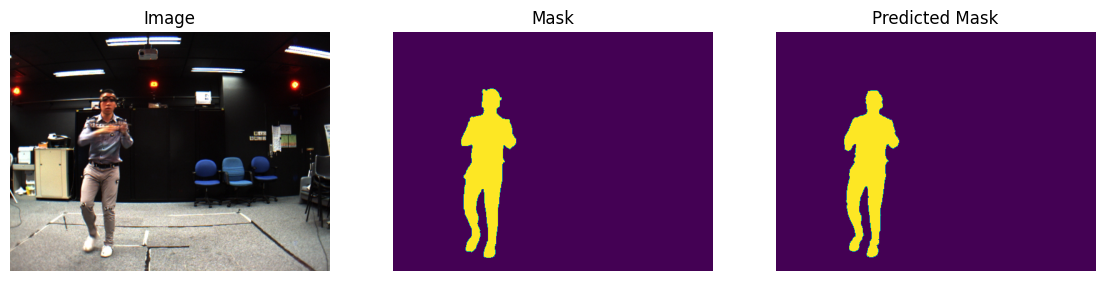

19/19 [==============================] - 6s 271ms/step


In [19]:
try: del train_gen, test_gen, model, pred # releasing memory before re-creating variables
except: pass

gc.collect()
K.clear_session()

max_epochs, batch_size, max_lr = (12, 8, 1E-3)
lr_decay_start, lr_decay_rate, lr_decay_step = (2, 0.1, 3)

with strategy.scope():
    ### Compile ###
    kwargs = {'opt':  Adam(clipnorm=1, amsgrad=True, epsilon=K.epsilon()),
              'loss': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, name='loss', reduction=reduction),
              'metrics': [tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=False, name='pixel-wise_CE'), 
                          'acc']}
    ### Callbacks ###
    alr = LearningRateScheduler(lambda t: max_lr*lr_decay_rate**((t-lr_decay_start)*(t>lr_decay_start)//lr_decay_step))
    es = EarlyStopping(monitor='val_pixel-wise_CE', mode='min', verbose=1, patience=5)
    dps = DisplaySegmentation(sample_idx=None, every_t=None, random_state=42)
    ### Create Model ###
    model = create_model(**kwargs)
train_gen = DataLoader(X[train_idx], y[train_idx], batch_size, shuffle=True, augment=True)
test_gen = DataLoader(X[test_idx], y[test_idx], batch_size*2)
if train_model: 
    model.fit(train_gen, validation_data = test_gen, epochs=max_epochs, verbose=1, callbacks=[alr, es, dps])
    model.save_weights('model.weights.h5')
else: model.load_weights('model.weights.h5')
pred = model.predict(test_gen)

## Check predictions

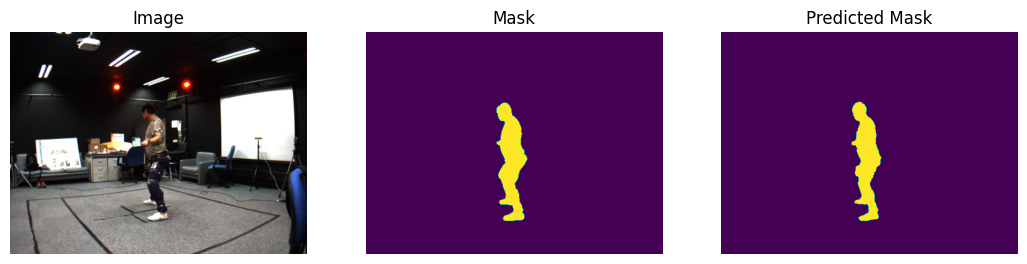

In [24]:
j = 100

fig, ax = plt.subplots(1,3,figsize=(13,27))
subtitles = ['Image', 'Mask', 'Predicted Mask']
image_list = [X[test_idx][j], y[test_idx][j], np.squeeze(pred[j].argmax(axis=-1))]
for i in range(3):
    ax[i].imshow(image_list[i])
    ax[i].set_title(subtitles[i])              
    ax[i].axis('off')
plt.show()

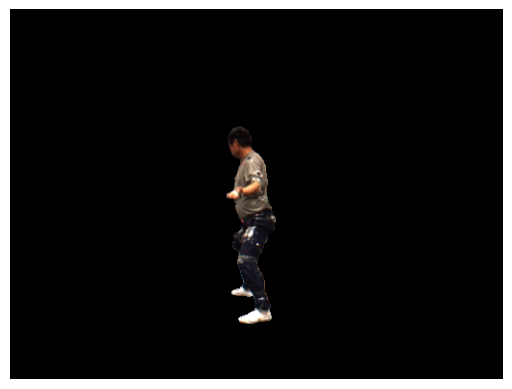

In [25]:
plt.imshow(np.multiply(image_list[0], np.expand_dims(image_list[-1], axis=-1)))
plt.axis('off')
plt.show()